In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pylab
from datetime import datetime
import seaborn as sns
import re
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

%matplotlib inline
sns.set_style("whitegrid")

# Import Dataset

In [ ]:
noshows = pd.read_csv('dataset/medical-appointment-no-shows/No-show-Issue-Comma-300k.csv')
noshows.head()

# Data Exploration

In [ ]:
noshows.describe()

In [ ]:
# Handcap --> Handicap
# AwaitingTime --> WaitTime 
# HiperTension --> Hypertension
# Sms_Reminder --> SMS_received 
noshows.columns

In [ ]:
noshows.groupby('Status').size()

In [ ]:
sns.countplot(x="Status", data=noshows)

In [7]:
# Nagative age should be fixed
noshows[noshows['Age'] < 0]['Age'].value_counts()

In [8]:
noshows[noshows['Age'] > 100]['Age'].value_counts()

101    13
103     4
102     4
113     3
104     2
108     1
Name: Age, dtype: int64

In [9]:
noshows['Gender'].value_counts()

F    200505
M     99495
Name: Gender, dtype: int64

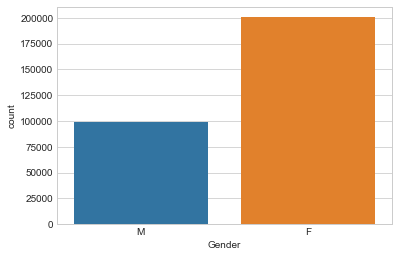

In [10]:
sns.countplot(x="Gender", data=noshows)

In [11]:
noshows['Sms_Reminder'].value_counts()

1    170654
0    128547
2       799
Name: Sms_Reminder, dtype: int64

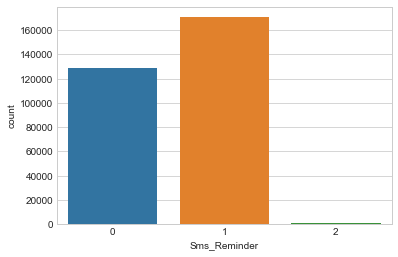

In [12]:
# sns.countplot(x="Sms_Reminder", data=noshows[noshows['Sms_Reminder'] > 0])
sns.countplot(x="Sms_Reminder", data=noshows)

In [13]:
# All 'AwaitingTime' are negative should fixed with absolute 
noshows[noshows['AwaitingTime'] > 0]['AwaitingTime'].value_counts()

Series([], Name: AwaitingTime, dtype: int64)

In [14]:
noshows[noshows['AwaitingTime'] <= -365]['AwaitingTime'].value_counts()

-398    1
Name: AwaitingTime, dtype: int64

In [15]:
noshows.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 15 columns):
Age                        300000 non-null int64
Gender                     300000 non-null object
AppointmentRegistration    300000 non-null object
ApointmentData             300000 non-null object
DayOfTheWeek               300000 non-null object
Status                     300000 non-null object
Diabetes                   300000 non-null int64
Alcoolism                  300000 non-null int64
HiperTension               300000 non-null int64
Handcap                    300000 non-null int64
Smokes                     300000 non-null int64
Scholarship                300000 non-null int64
Tuberculosis               300000 non-null int64
Sms_Reminder               300000 non-null int64
AwaitingTime               300000 non-null int64
dtypes: int64(10), object(5)
memory usage: 28.6+ MB


### Rename  
Handcap --> Handicap  
AwaitingTime --> WaitTime   
HiperTension --> Hypertension  
Sms_Reminder --> SMS_received  

### Negative age  
Nagative age should be fixed

### Absolute 'AwaitingTime'  
All 'AwaitingTime' are negative should fixed with absolute 

### Convert quality   
Gender	--> GenderB (M=0, F=1)  
AppointmentRegistration	--> ScheduledDay (datetime64)    
ApointmentData	--> AppointmentDay (datetime64)  
DayOfTheWeek --> dayofweek (0-6)  
Status --> No-showB (Show-Up=0, No-Show=1)

# Data wrangling

In [16]:
# rename columns
noshows.rename(columns = {'HiperTension':'Hypertension',
                         'Handcap': 'Handicap',
                         'AwaitingTime':'WaitTime',
                         'Sms_Reminder':'SMS_received',
                         'AppointmentRegistration':'ScheduledDay',
                         'ApointmentData':'AppointmentDay',
                         'DayOfTheWeek':'dayofweek '
                         }, inplace = True)

noshows.columns

Index(['Age', 'Gender', 'ScheduledDay', 'AppointmentDay', 'dayofweek ',
       'Status', 'Diabetes', 'Alcoolism', 'Hypertension', 'Handicap', 'Smokes',
       'Scholarship', 'Tuberculosis', 'SMS_received', 'WaitTime'],
      dtype='object')

In [17]:
# Convert types
noshows.ScheduledDay = noshows.ScheduledDay.apply(np.datetime64)
noshows.AppointmentDay = noshows.AppointmentDay.apply(np.datetime64)

noshows['WaitTime'] = (noshows.AppointmentDay - noshows.ScheduledDay).dt.days
noshows['No-showB']= noshows['Status'].apply(lambda x: 0 if x =="Show-Up" else 1)
noshows['GenderB'] = noshows['Gender'].apply(lambda x: 0 if x =="M" else 1)
noshows['dayofweek'] = noshows.AppointmentDay.dt.weekday
noshows['isHandcap'] = noshows['Handicap'].apply(lambda x: 1 if x != 0 else x)
noshows

,Age,Gender,ScheduledDay,AppointmentDay,dayofweek,Status,Diabetes,Alcoolism,Hypertension,Handicap,Smokes,Scholarship,Tuberculosis,SMS_received,WaitTime,No-showB,GenderB,dayofweek,isHandcap
0,19,M,2014-12-16 14:46:25,2015-01-14,Wednesday,Show-Up,0,0,0,0,0,0,0,0,28,0,0,2,0
1,24,F,2015-08-18 07:01:26,2015-08-19,Wednesday,Show-Up,0,0,0,0,0,0,0,0,0,0,1,2,0
2,4,F,2014-02-17 12:53:46,2014-02-18,Tuesday,Show-Up,0,0,0,0,0,0,0,0,0,0,1,1,0
3,5,M,2014-07-23 17:02:11,2014-08-07,Thursday,Show-Up,0,0,0,0,0,0,0,1,14,0,0,3,0
4,38,M,2015-10-21 15:20:09,2015-10-27,Tuesday,Show-Up,0,0,0,0,0,0,0,1,5,0,0,1,0
5,5,F,2014-06-17 06:47:27,2014-07-22,Tuesday,No-Show,0,0,0,0,0,0,0,1,34,1,1,1,0
6,46,F,2015-06-19 19:53:58,2015-07-07,Tuesday,Show-Up,0,0,0,0,0,0,0,1,17,0,1,1,0
7,4,F,2015-08-07 08:19:19,2015-08-21,Friday,Show-Up,0,0,0,0,0,1,0,1,13,0,1,4,0
8,20,F,2014-10-14 11:46:36,2014-10-28,Tuesday,Show-Up,0,0,0,0,0,0,0,0,13,0,1,1,0
9,51,F,2014-06-13 07:50:43,2014-06-17,Tuesday,Show-Up,1,0,1,0,0,0,0,1,3,0,1,1,0


In [18]:
noshows.describe()

,Age,Diabetes,Alcoolism,Hypertension,Handicap,Smokes,Scholarship,Tuberculosis,SMS_received,WaitTime,No-showB,GenderB,dayofweek,isHandcap
count,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000
mean,37.808017,0.077967,0.025010,0.215890,0.020523,0.052370,0.096897,0.000450,0.574173,12.841813,0.302437,0.668350,1.962120,0.018657
std,22.809014,0.268120,0.156156,0.411439,0.155934,0.222772,0.295818,0.021208,0.499826,15.687697,0.459314,0.470807,1.394653,0.135309
min,-2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,1.000000,0.000000
50%,38.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,7.000000,0.000000,1.000000,2.000000,0.000000
75%,56.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,19.000000,1.000000,1.000000,3.000000,0.000000
max,113.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,1.000000,2.000000,397.000000,1.000000,1.000000,6.000000,1.000000


In [50]:
# filter outlier, Negative age
noshows = noshows[noshows.Age >= 0]

In [51]:
def ageRange (x):
    if x < 0 : return 0               
    elif x >= 0 and x < 10 : return 1  
    elif x >=10 and x < 20 : return 2  
    elif x >=20 and x < 30 : return 3 
    elif x >=30 and x < 40 : return 4 
    elif x >=40 and x < 50 : return 5 
    elif x >=50 and x < 60 : return 6  
    elif x >=60 and x < 70 : return 7 
    elif x >=70 and x < 80 : return 8 
    elif x >=80 and x < 90 : return 9  
    elif x >=90 and x < 100 : return 10 
    else: return 11                    

noshows['AgeClass']= noshows['Age'].apply(ageRange)

In [52]:
noshows.describe()

,Age,Diabetes,Alcoolism,Hypertension,Handicap,Smokes,Scholarship,Tuberculosis,SMS_received,WaitTime,No-showB,GenderB,dayofweek,isHandcap,AgeClass
count,299994.000000,299994.000000,299994.000000,299994.000000,299994.000000,299994.000000,299994.000000,299994.000000,299994.000000,299994.000000,299994.000000,299994.000000,299994.000000,299994.000000,299994.000000
mean,37.808796,0.077968,0.025011,0.215894,0.020524,0.052371,0.096899,0.000450,0.574168,12.841787,0.302436,0.668343,1.962109,0.018657,4.348110
std,22.808576,0.268122,0.156157,0.411442,0.155936,0.222775,0.295820,0.021209,0.499827,15.687770,0.459314,0.470809,1.394649,0.135311,2.269054
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,1.000000,0.000000,2.000000
50%,38.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,7.000000,0.000000,1.000000,2.000000,0.000000,4.000000
75%,56.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,19.000000,1.000000,1.000000,3.000000,0.000000,6.000000
max,113.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,1.000000,2.000000,397.000000,1.000000,1.000000,6.000000,1.000000,11.000000


In [53]:
noshows.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299994 entries, 0 to 299999
Data columns (total 20 columns):
Age               299994 non-null int64
Gender            299994 non-null object
ScheduledDay      299994 non-null datetime64[ns]
AppointmentDay    299994 non-null datetime64[ns]
dayofweek         299994 non-null object
Status            299994 non-null object
Diabetes          299994 non-null int64
Alcoolism         299994 non-null int64
Hypertension      299994 non-null int64
Handicap          299994 non-null int64
Smokes            299994 non-null int64
Scholarship       299994 non-null int64
Tuberculosis      299994 non-null int64
SMS_received      299994 non-null int64
WaitTime          299994 non-null int64
No-showB          299994 non-null int64
GenderB           299994 non-null int64
dayofweek         299994 non-null int64
isHandcap         299994 non-null int64
AgeClass          299994 non-null int64
dtypes: datetime64[ns](2), int64(15), object(3)
memory usage: 44.6+ 

In [54]:
bandpass_filterlist = ['No-showB', 'GenderB', 'Age', 'AgeClass'
                       , 'Scholarship', 'Diabetes', 'Alcoolism', 'Hypertension','Tuberculosis'
                       , 'Handicap', 'Smokes', 'isHandcap', 'SMS_received', 'WaitTime',
                        'dayofweek'
                      ]
noshows_data = noshows.loc[:, bandpass_filterlist]
noshows_data.head()

,No-showB,GenderB,Age,AgeClass,Scholarship,Diabetes,Alcoolism,Hypertension,Tuberculosis,Handicap,Smokes,isHandcap,SMS_received,WaitTime,dayofweek
0,0,0,19,2,0,0,0,0,0,0,0,0,0,28,2
1,0,1,24,3,0,0,0,0,0,0,0,0,0,0,2
2,0,1,4,1,0,0,0,0,0,0,0,0,0,0,1
3,0,0,5,1,0,0,0,0,0,0,0,0,1,14,3
4,0,0,38,4,0,0,0,0,0,0,0,0,1,5,1


### Visulization and Exploration of cleaned data

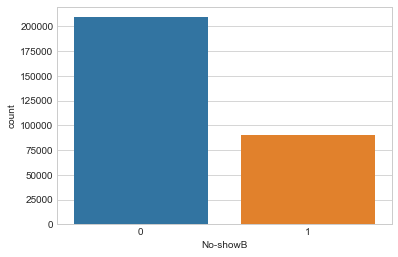

In [55]:
target = sns.countplot(x="No-showB", data=noshows_data)

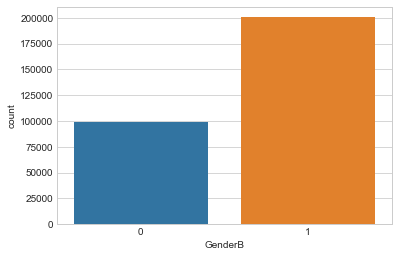

In [56]:
sns.countplot(x="GenderB", data=noshows_data)

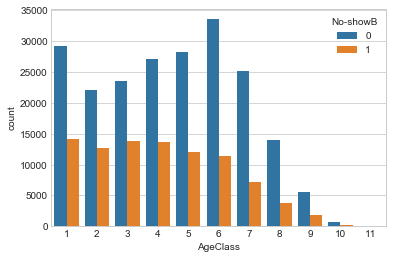

In [57]:
sns.countplot(x="AgeClass", hue = "No-showB", data=noshows_data)

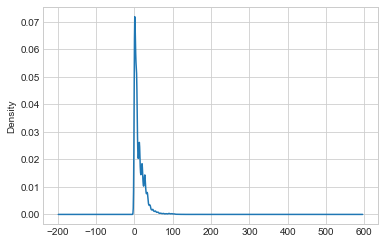

In [58]:
noshows_data.WaitTime.plot(kind='kde')

In [59]:
noshows_data['isHandcap'].value_counts()
# target = sns.countplot(x="isHandcap", data=noshows_data)

0    294397
1      5597
Name: isHandcap, dtype: int64

In [60]:
noshows_data['SMS_received'].value_counts()
# target = sns.countplot(x="SMS_received", data=noshows_data)

1    170649
0    128546
2       799
Name: SMS_received, dtype: int64

In [61]:
noshows_data['dayofweek'].value_counts()

2    63495
1    62774
3    60260
0    59297
4    52769
5     1393
6        6
Name: dayofweek, dtype: int64

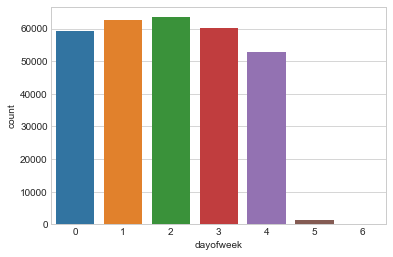

In [62]:
sns.countplot(x="dayofweek", data=noshows_data)

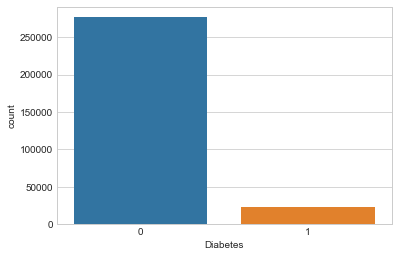

In [254]:
sns.countplot(x="Diabetes", data=noshows_data)

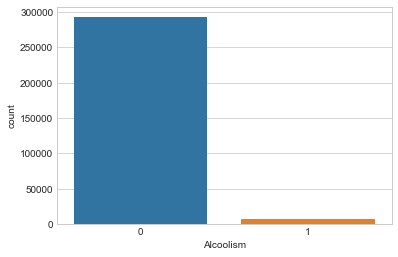

In [255]:
sns.countplot(x="Alcoolism", data=noshows_data)

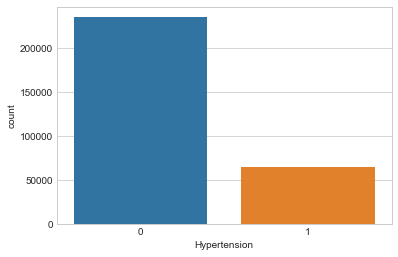

In [256]:
sns.countplot(x="Hypertension", data=noshows_data)

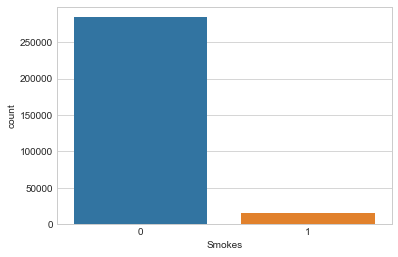

In [257]:
sns.countplot(x="Smokes", data=noshows_data)

In [259]:
# sns.countplot(x="Tuberculosis", data=noshows_data)
noshows_data['Tuberculosis'].value_counts()

0    299859
1       135
Name: Tuberculosis, dtype: int64

# Model

In [63]:
y = noshows_data.loc[:, 'No-showB'].values
y

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [64]:
feature_list = ['GenderB', 
                'Age', 
                'AgeClass', 
                'Scholarship', 
                'Diabetes', 
                'Alcoolism', 
                'Hypertension',
                'Tuberculosis', 
                'Handicap', 
                'Smokes', 
                'isHandcap', 
                'SMS_received', 
                'WaitTime',
                'dayofweek'
                ]

In [65]:
feature_list = ['GenderB', 
                'AgeClass', 
                'Scholarship', 
                'Diabetes', 
                'Alcoolism', 
                'Hypertension',
                'Tuberculosis', 
                'Smokes', 
                'isHandcap', 
                'WaitTime'
                ]

In [138]:

feature_list = ['GenderB', 
                'AgeClass', 
                'Scholarship', 
                'Diabetes', 
                'Alcoolism', 
                'Hypertension',
                'Tuberculosis', 
                'isHandcap', 
                'WaitTime'
                ]

In [239]:
## remove 'Scholarship' good for model LogisticRegression and naive_bayes: MultinomialNB
feature_list = ['GenderB', 
                'AgeClass', 
                'Diabetes', 
                'Alcoolism', 
                'Hypertension',
                'Tuberculosis', 
                'isHandcap', 
                'WaitTime'
                ]

In [260]:
feature_list = ['GenderB', 
                'AgeClass', 
                'Diabetes', 
                'Alcoolism', 
                'Hypertension', 
                'isHandcap', 
                'WaitTime'
                ]

In [261]:
X = noshows_data.loc[:, feature_list]
X.head()

,GenderB,AgeClass,Diabetes,Alcoolism,Hypertension,isHandcap,WaitTime
0,0,2,0,0,0,0,28
1,1,3,0,0,0,0,0
2,1,1,0,0,0,0,0
3,0,1,0,0,0,0,14
4,0,4,0,0,0,0,5


In [275]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=1, stratify=y)

### LogisticRegression

In [276]:
LogReg = LogisticRegression()
LogReg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [277]:
LogReg.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': 1,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [278]:
# Test: predict train data
y_pred = LogReg.predict(X_train)

# evaluate score
print(f'Accuracy: {(y_train==y_pred).mean() * 100} %')
print(f'Accuracy: {accuracy_score(y_train,y_pred) * 100} %')
print(classification_report(y_train, y_pred))

Accuracy: 64.53360667740519 %
Accuracy: 64.53360667740519 %
             precision    recall  f1-score   support

          0       0.65      0.99      0.78      4415
          1       0.43      0.01      0.02      2414

avg / total       0.57      0.65      0.51      6829



In [279]:
confusion_matrix(y_train, y_pred)

array([[4382,   33],
       [2389,   25]], dtype=int64)

In [280]:
# Test: predict test data
y_pred = LogReg.predict(X_test)
# evaluate score
print(f'Accuracy: {(y_test==y_pred).mean() * 100} %')
print(f'Accuracy: {accuracy_score(y_test,y_pred) * 100} %')
print(classification_report(y_test, y_pred))

Accuracy: 64.46351931330472 %
Accuracy: 64.46351931330472 %
             precision    recall  f1-score   support

          0       0.65      0.99      0.78      2259
          1       0.43      0.01      0.03      1236

avg / total       0.57      0.64      0.52      3495



In [281]:
confusion_matrix(y_test, y_pred)

array([[2235,   24],
       [1218,   18]], dtype=int64)

### naive_bayes: MultinomialNB

In [282]:
from sklearn.naive_bayes import MultinomialNB
clf =  MultinomialNB().fit(X_train, y_train)
y_pred = clf.predict(X_train)

# evaluate score
print(f'Accuracy: {(y_train==y_pred).mean() * 100} %')
print(f'Accuracy: {accuracy_score(y_train,y_pred) * 100} %')
print(classification_report(y_train, y_pred))

Accuracy: 60.697027383218625 %
Accuracy: 60.697027383218625 %
             precision    recall  f1-score   support

          0       0.67      0.78      0.72      4415
          1       0.42      0.30      0.35      2414

avg / total       0.58      0.61      0.59      6829



In [283]:
confusion_matrix(y_train, y_pred)

array([[3424,  991],
       [1693,  721]], dtype=int64)

In [284]:
# Test: predict test data
y_pred = clf.predict(X_test)
# evaluate score
print(f'Accuracy: {(y_test==y_pred).mean() * 100} %')
print(f'Accuracy: {accuracy_score(y_test,y_pred) * 100} %')
print(classification_report(y_test, y_pred))

Accuracy: 61.05865522174535 %
Accuracy: 61.05865522174535 %
             precision    recall  f1-score   support

          0       0.67      0.79      0.72      2259
          1       0.43      0.29      0.34      1236

avg / total       0.58      0.61      0.59      3495



In [285]:
confusion_matrix(y_test, y_pred)

array([[1777,  482],
       [ 879,  357]], dtype=int64)

### Decision Tree

In [286]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)

# evaluate score
print(f'Accuracy: {(y_train==y_pred).mean() * 100} %')
print(f'Accuracy: {accuracy_score(y_train,y_pred) * 100} %')
print(classification_report(y_train, y_pred))

Accuracy: 73.37823985942305 %
Accuracy: 73.37823985942305 %
             precision    recall  f1-score   support

          0       0.73      0.93      0.82      4415
          1       0.75      0.37      0.50      2414

avg / total       0.74      0.73      0.71      6829



In [287]:
confusion_matrix(y_train, y_pred)

array([[4109,  306],
       [1512,  902]], dtype=int64)

In [288]:
# Test: predict test data
y_pred = clf.predict(X_test)
# evaluate score
print(f'Accuracy: {(y_test==y_pred).mean() * 100} %')
print(f'Accuracy: {accuracy_score(y_test,y_pred) * 100} %')
print(classification_report(y_test, y_pred))

Accuracy: 60.60085836909871 %
Accuracy: 60.60085836909871 %
             precision    recall  f1-score   support

          0       0.65      0.83      0.73      2259
          1       0.39      0.20      0.26      1236

avg / total       0.56      0.61      0.56      3495



In [289]:
confusion_matrix(y_test, y_pred)

array([[1876,  383],
       [ 994,  242]], dtype=int64)

### GradientBoostingClassifier

In [290]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier()
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)

# evaluate score
print(f'Accuracy: {(y_train==y_pred).mean() * 100} %')
print(f'Accuracy: {accuracy_score(y_train,y_pred) * 100} %')
print(classification_report(y_train, y_pred))

Accuracy: 66.01259335188168 %
Accuracy: 66.01259335188168 %
             precision    recall  f1-score   support

          0       0.66      0.98      0.79      4415
          1       0.70      0.07      0.12      2414

avg / total       0.67      0.66      0.55      6829



In [291]:
confusion_matrix(y_train, y_pred)

array([[4348,   67],
       [2254,  160]], dtype=int64)

In [292]:
# Test: predict test data
y_pred = clf.predict(X_test)
# evaluate score
print(f'Accuracy: {(y_test==y_pred).mean() * 100} %')
print(f'Accuracy: {accuracy_score(y_test,y_pred) * 100} %')
print(classification_report(y_test, y_pred))

Accuracy: 64.49213161659515 %
Accuracy: 64.49213161659515 %
             precision    recall  f1-score   support

          0       0.65      0.97      0.78      2259
          1       0.48      0.05      0.09      1236

avg / total       0.59      0.64      0.53      3495



In [293]:
confusion_matrix(y_test, y_pred)

array([[2196,   63],
       [1178,   58]], dtype=int64)